In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
import tools

from tools.FV3_tools import read_solo_fields
from tools.WRF_tools import read_wrf_fields
from tools.CM1_tools import read_cm1_fields

import pickle
from tools.cbook import pickle2Obj

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
models = { 'cm1': pickle2Obj('precip/cm1_squall_3km_accum_prec.pkl',retObj=False),
           'wrf': pickle2Obj('precip/wrf_squall_3km_accum_prec.pkl', retObj=False),
           'solo': pickle2Obj('precip/solo_squall_3km_accum_prec.pkl',retObj=False),
          'mpas': pickle2Obj('precip/mpas_squall_3km_accum_prec.pkl',retObj=False),
           # 'solo2': pickle2Obj('precip/solo_squall_3km_nord2_accum_prec.pkl',retObj=False),
           # 'solo1': pickle2Obj('precip/solo_squall_3km_nord1_accum_prec.pkl',retObj=False) 
         }

# models = { 'cm1': pickle2Obj('precip/cm1_squall_1km_accum_prec.pkl',retObj=False),
#            'wrf': pickle2Obj('precip/wrf_squall_1km_accum_prec.pkl', retObj=False),
#            'solo': pickle2Obj('precip/solo_squall_1km_orig_accum_prec.pkl',retObj=False)}

models['solo']['C2000_06']['accum_prec'].shape

(24, 256, 256)

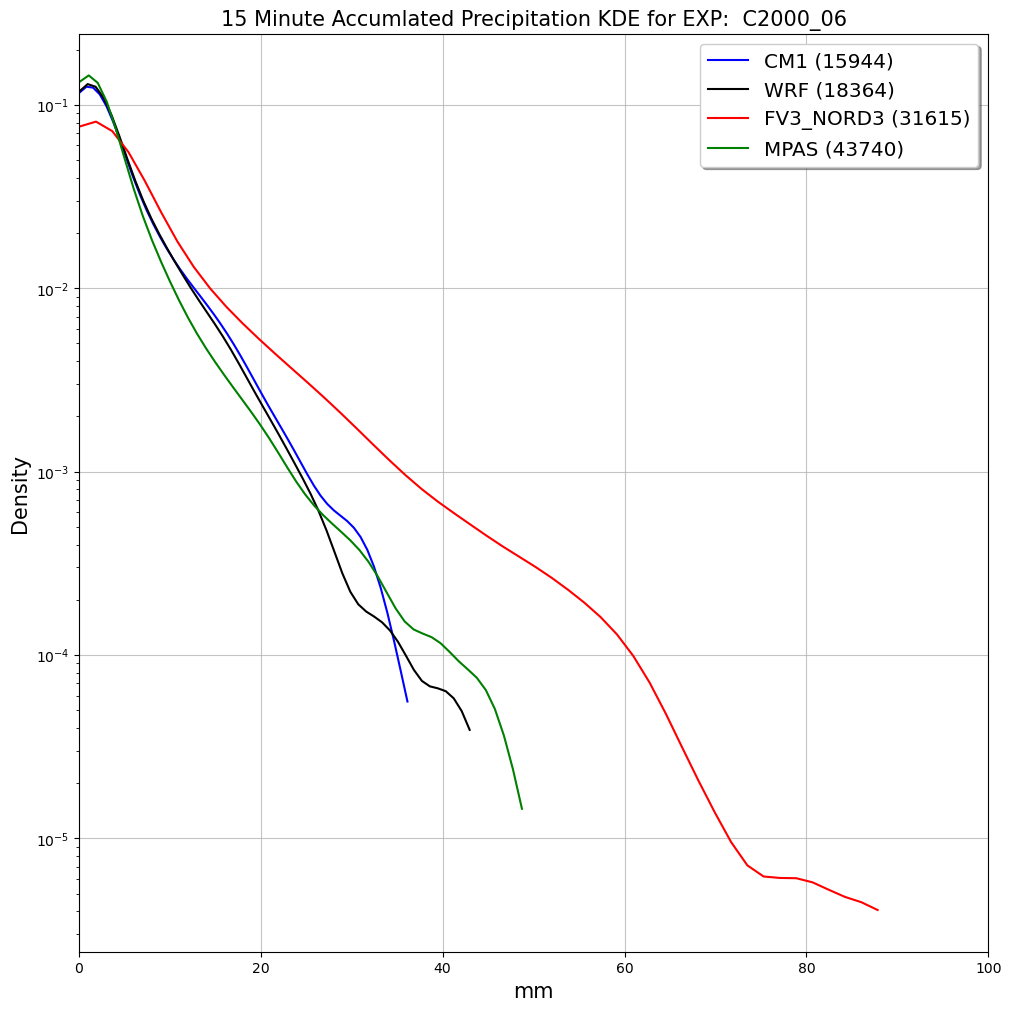

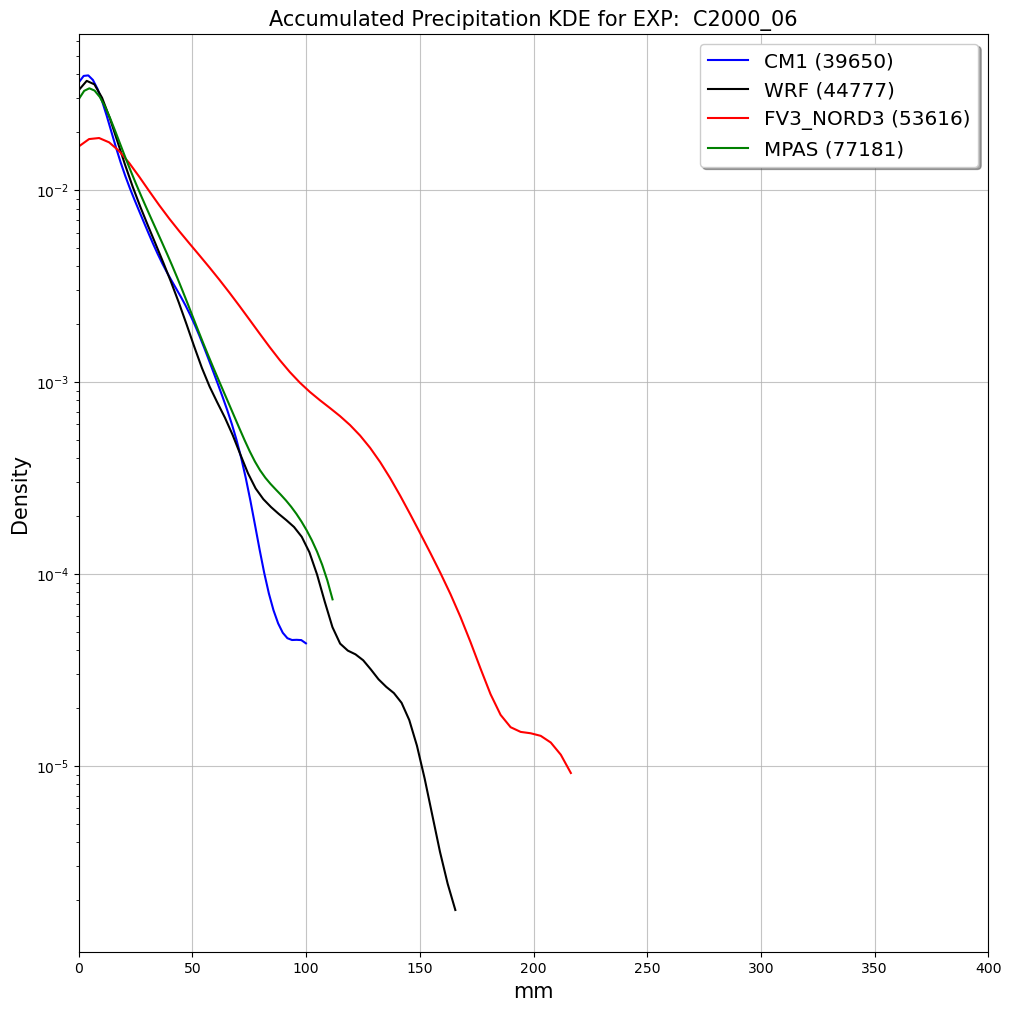

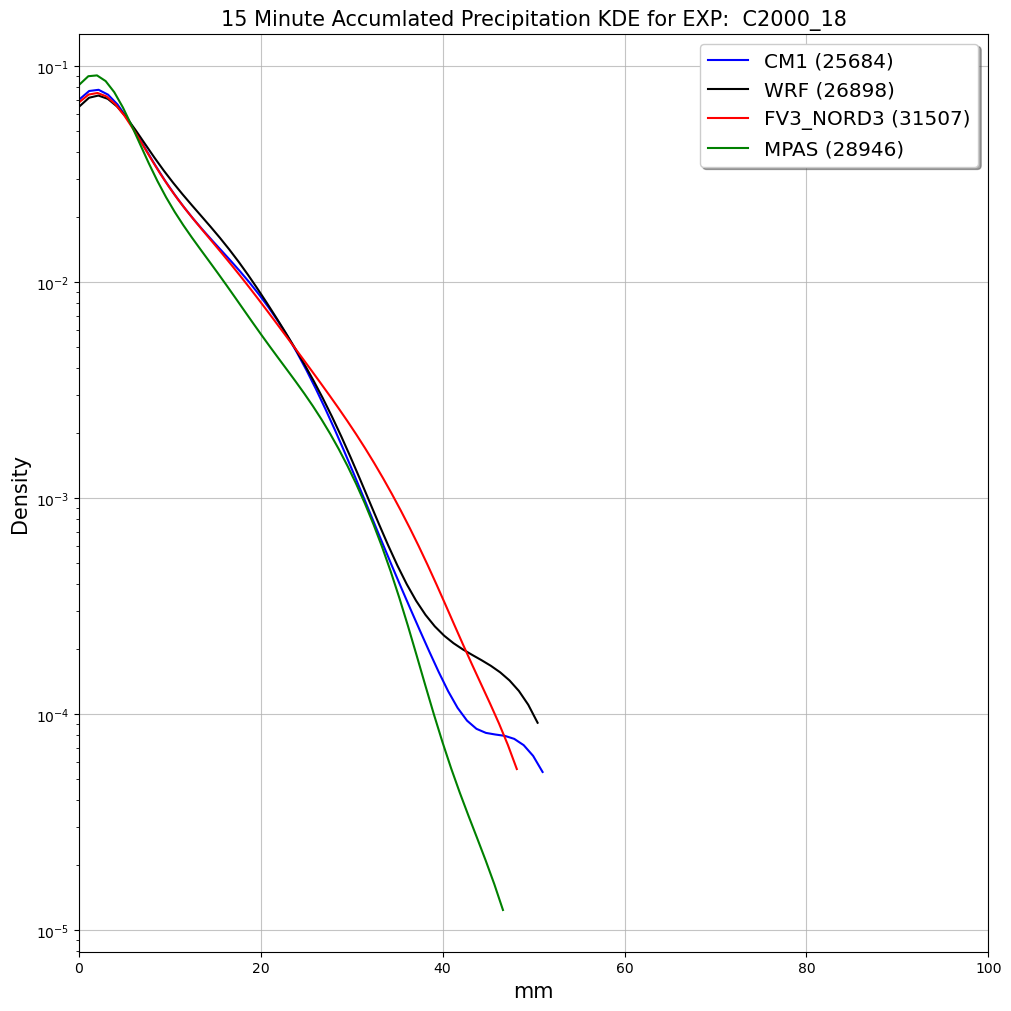

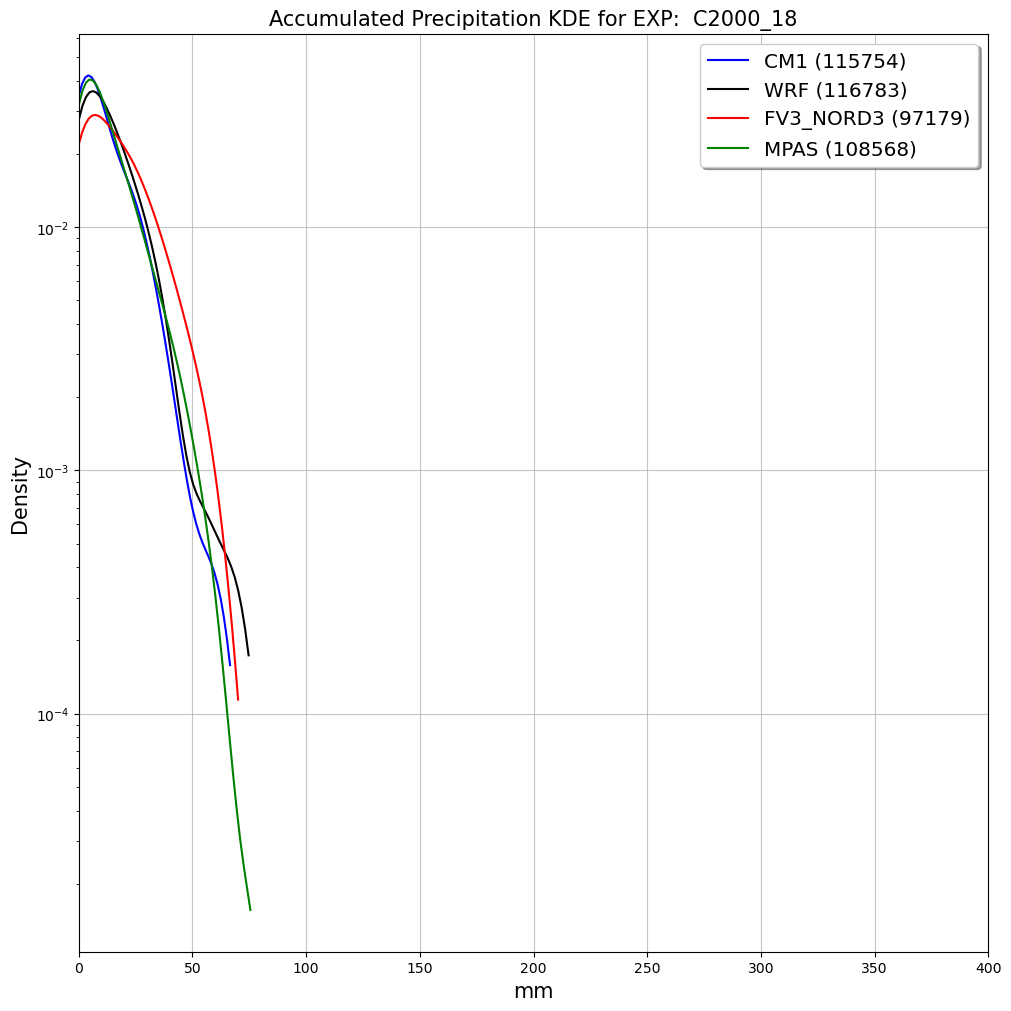

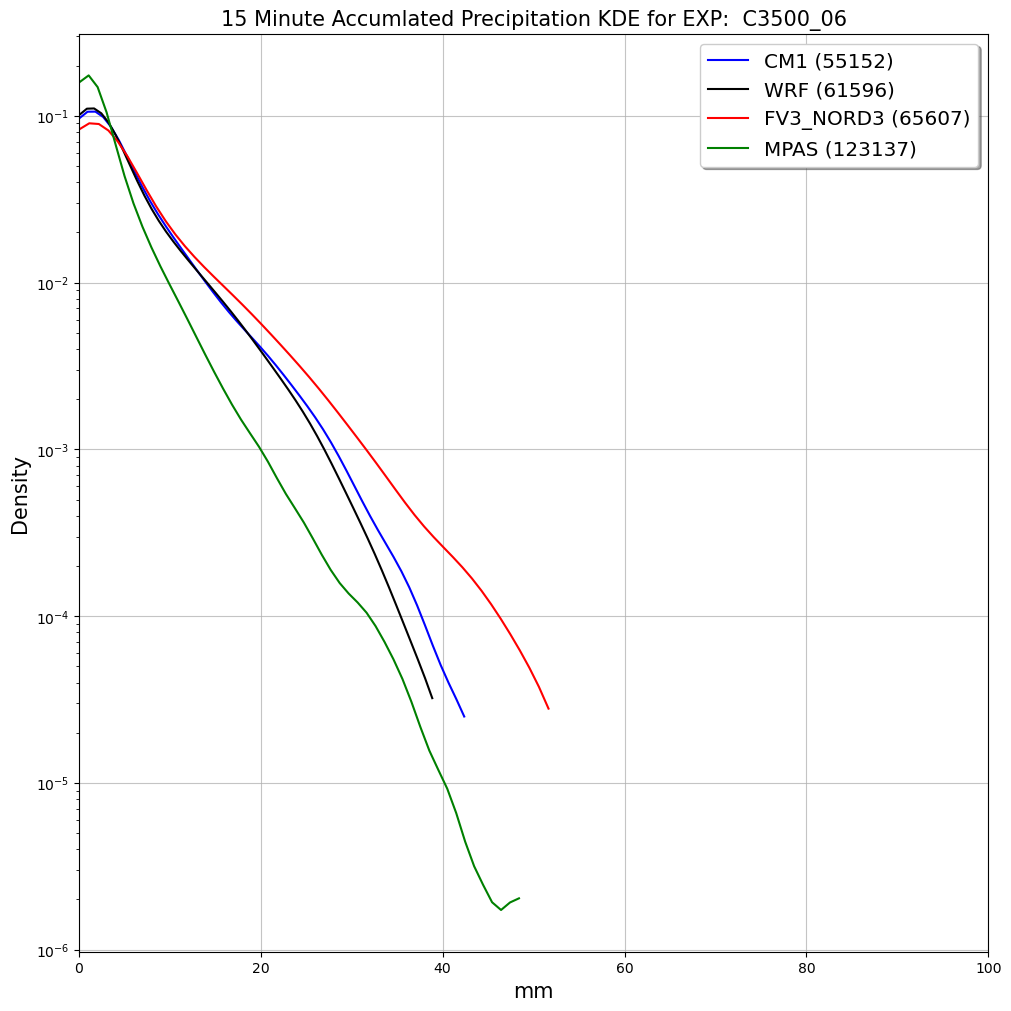

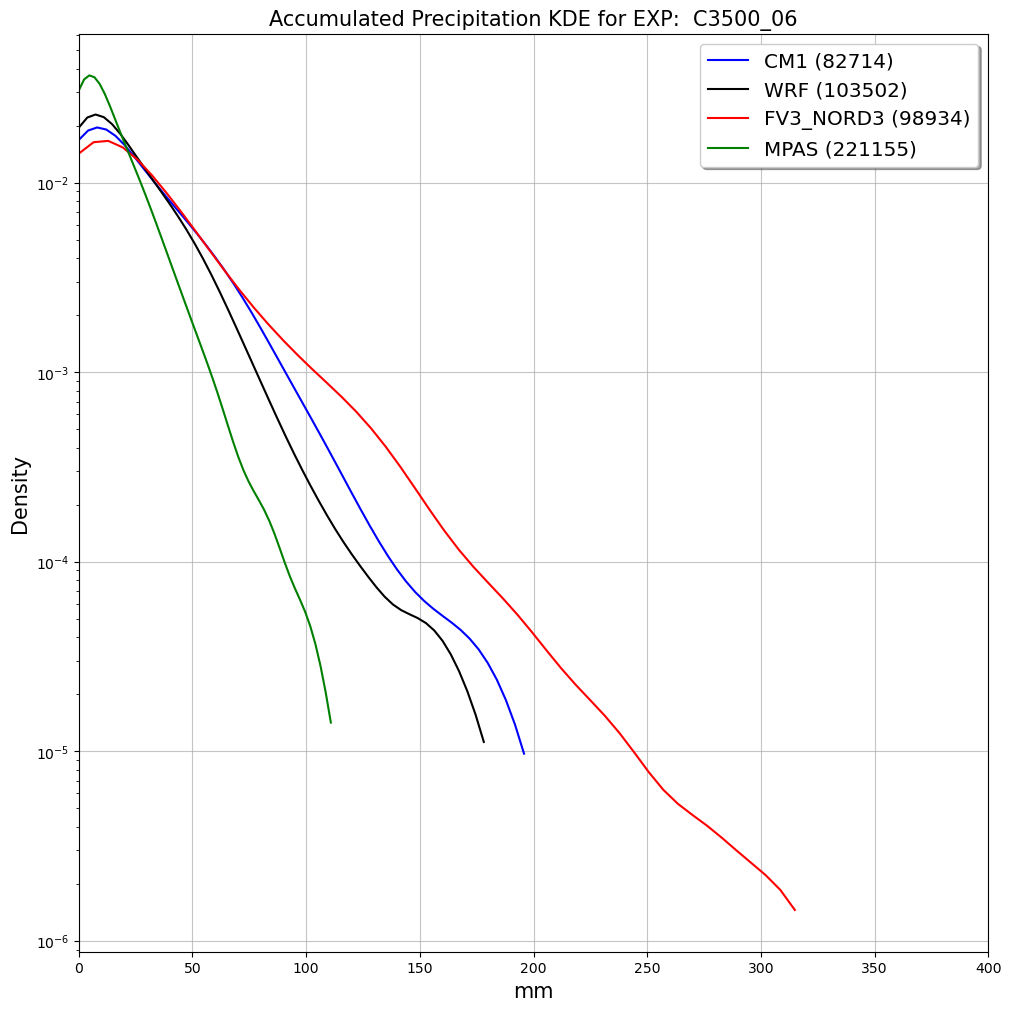

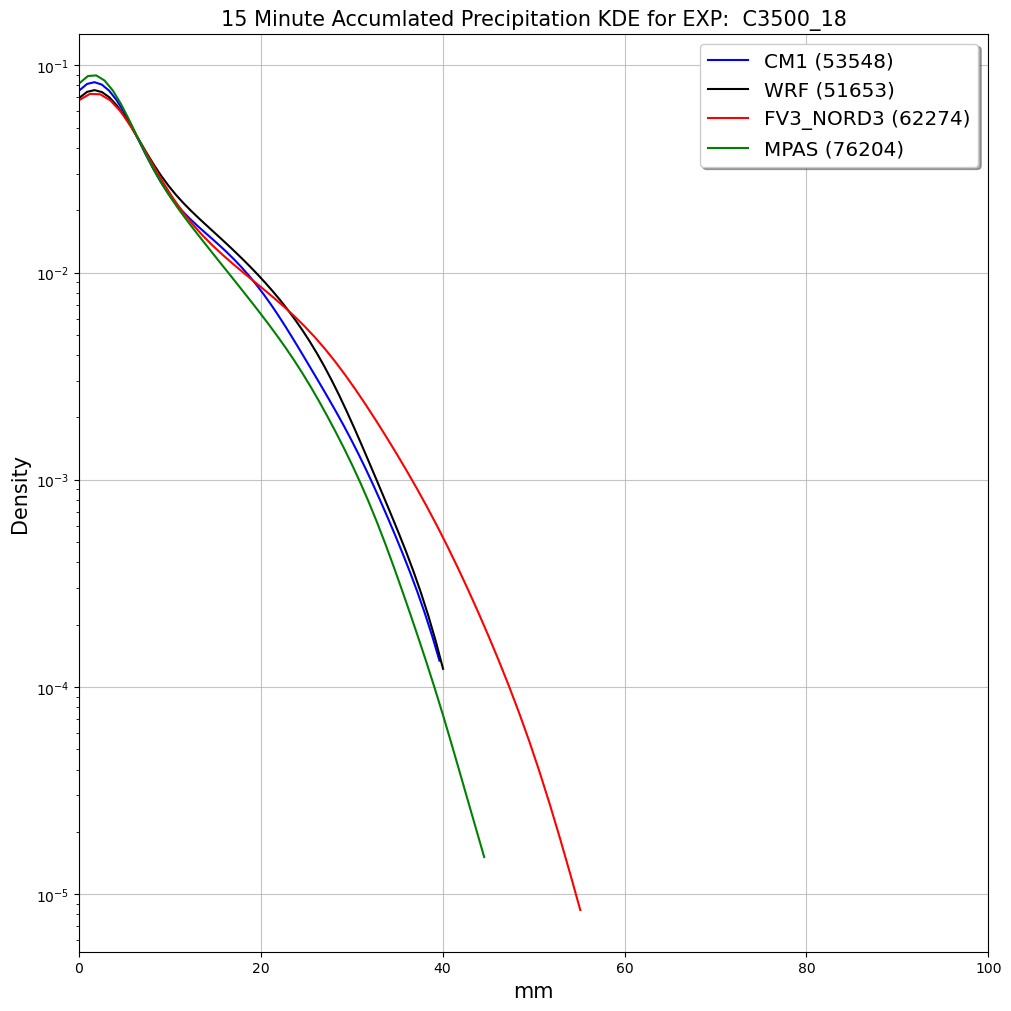

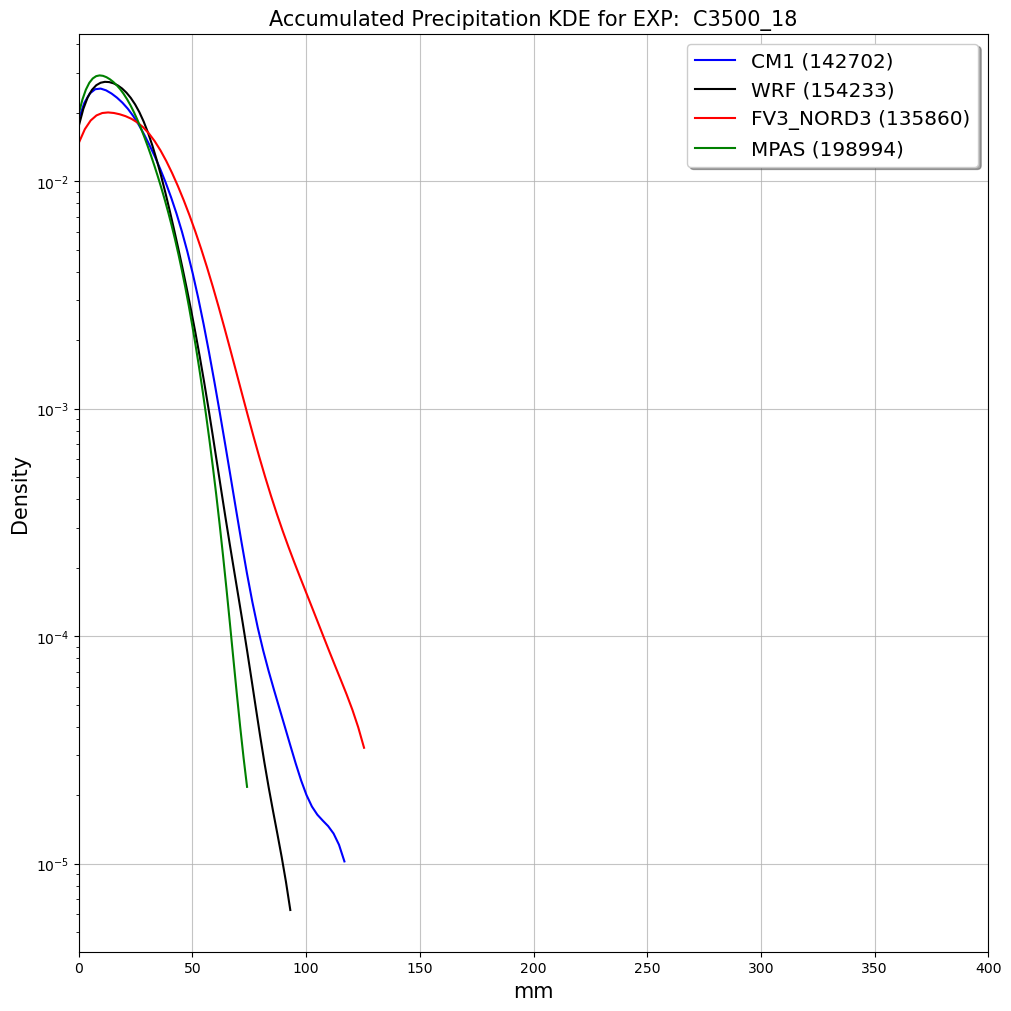

In [4]:
from scipy.stats import gaussian_kde


def precip_histogram(models, label, all_times=False):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))
    
    if all_times:
        
        xlim = [0.0, 400.]
            
    else:
        xlim = [0.0, 100.]
    
    for key in models.keys():
        
        if all_times:
            
            precip_dt = models[key][label]['accum_prec']
            
        else:
    
    # first, compute the increments in time of precip
    
            inv = models[key][label]['accum_prec'][::-1]
    
            precip_dt = inv[0:-1] - inv[1:]
        
    # get rid of zeros...
    
        data_flat = precip_dt.flatten()
        
        data_no_zero = data_flat[data_flat >= 1.0e-1]
        
        hist, bin_edges = np.histogram(data_no_zero)

        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.5)
        y_sp        = kde_sp.pdf(eval_points)
        
        if key == 'solo':
            ax.plot(eval_points, y_sp, color='r', label='FV3_NORD3 (%d)' % data_no_zero.shape)
            
        if key == 'solo2':
            ax.plot(eval_points, y_sp, color='r', linestyle='--', label='FV3_NORD2 (%d)' % data_no_zero.shape)
                    
        if key == 'solo1':
            ax.plot(eval_points, y_sp, color='r', linestyle=':', label='FV3_NORD1 (%d)' % data_no_zero.shape)

        if key == 'wrf':
            ax.plot(eval_points, y_sp, color='k', label='WRF (%d)' % data_no_zero.shape)
            
        if key == 'cm1':
            ax.plot(eval_points, y_sp, color='b', label='CM1 (%d)' % data_no_zero.shape)
            
        if key == 'mpas':
            ax.plot(eval_points, y_sp, color='g', label='MPAS (%d)' % data_no_zero.shape)
    
    ax.set_xlim(xlim[:])
    ax.set_yscale("log")
    plt.grid(axis='y', alpha=0.75)
    plt.grid(axis='x', alpha=0.75)
    ax.set_xlabel('mm',fontsize=15)
    ax.set_ylabel('Density',fontsize=15)
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    if all_times:
        ax.set_title('Accumulated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
        plt.savefig("Total_Accumlated_Precipitation_KDE_Experiment_%s.png" % (label))
    else:
        ax.set_title('15 Minute Accumlated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
        plt.savefig("15_Minute_Accumlated_Precipitation_KDE_Experiment_%s.png" % (label))
    
    plt.show()
    
precip_histogram(models, 'C2000_06')
#precip_histogram(models, 'C2000_12')
precip_histogram(models, 'C2000_06', all_times = True)
precip_histogram(models, 'C2000_18')
#precip_histogram(models, 'C2000_12')
precip_histogram(models, 'C2000_18', all_times = True)
precip_histogram(models, 'C3500_06')
#precip_histogram(models, 'C2000_12')
precip_histogram(models, 'C3500_06', all_times = True)
precip_histogram(models, 'C3500_18')
#precip_histogram(models, 'C2000_12')
precip_histogram(models, 'C3500_18', all_times = True)

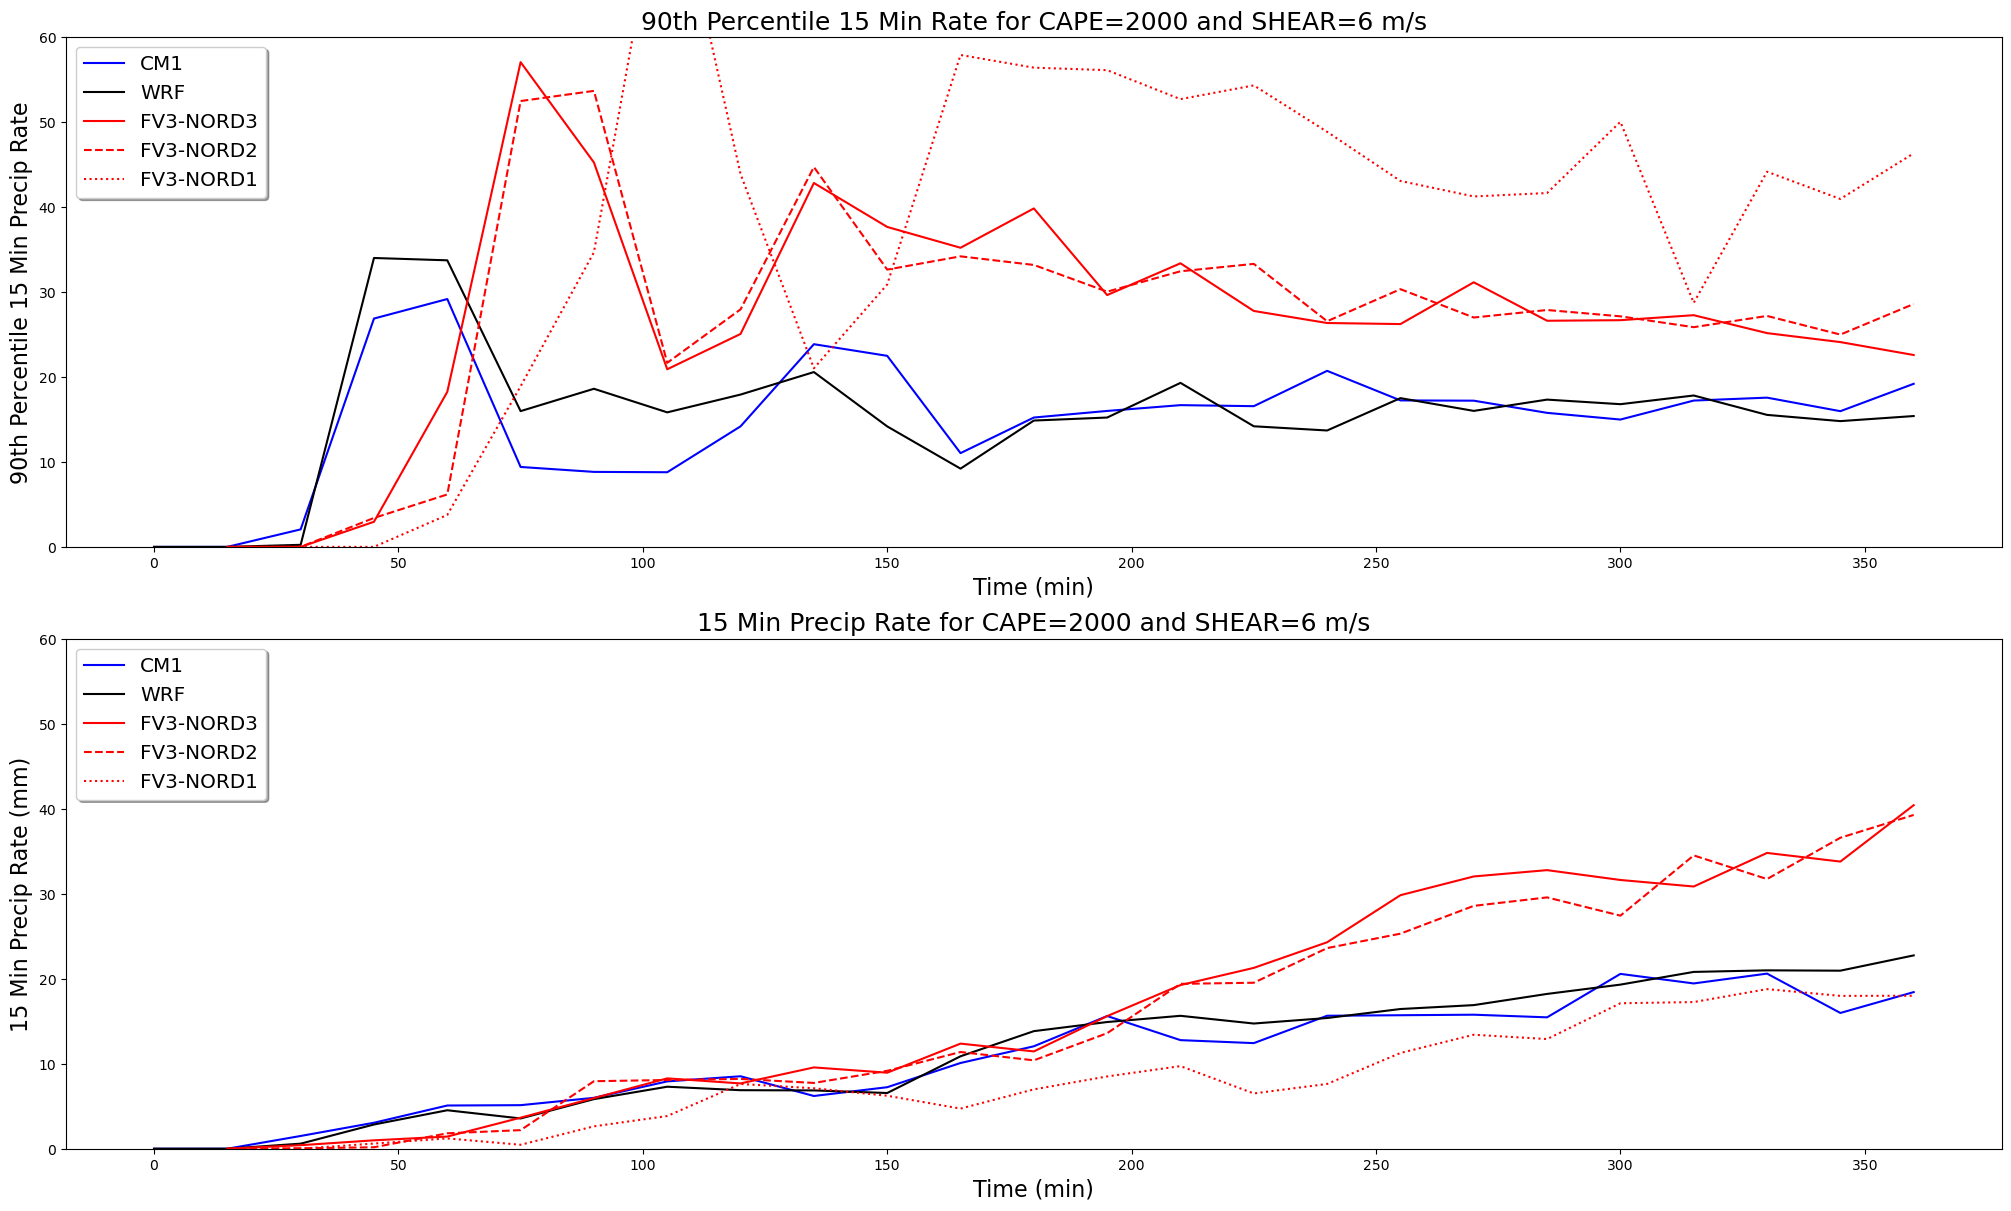

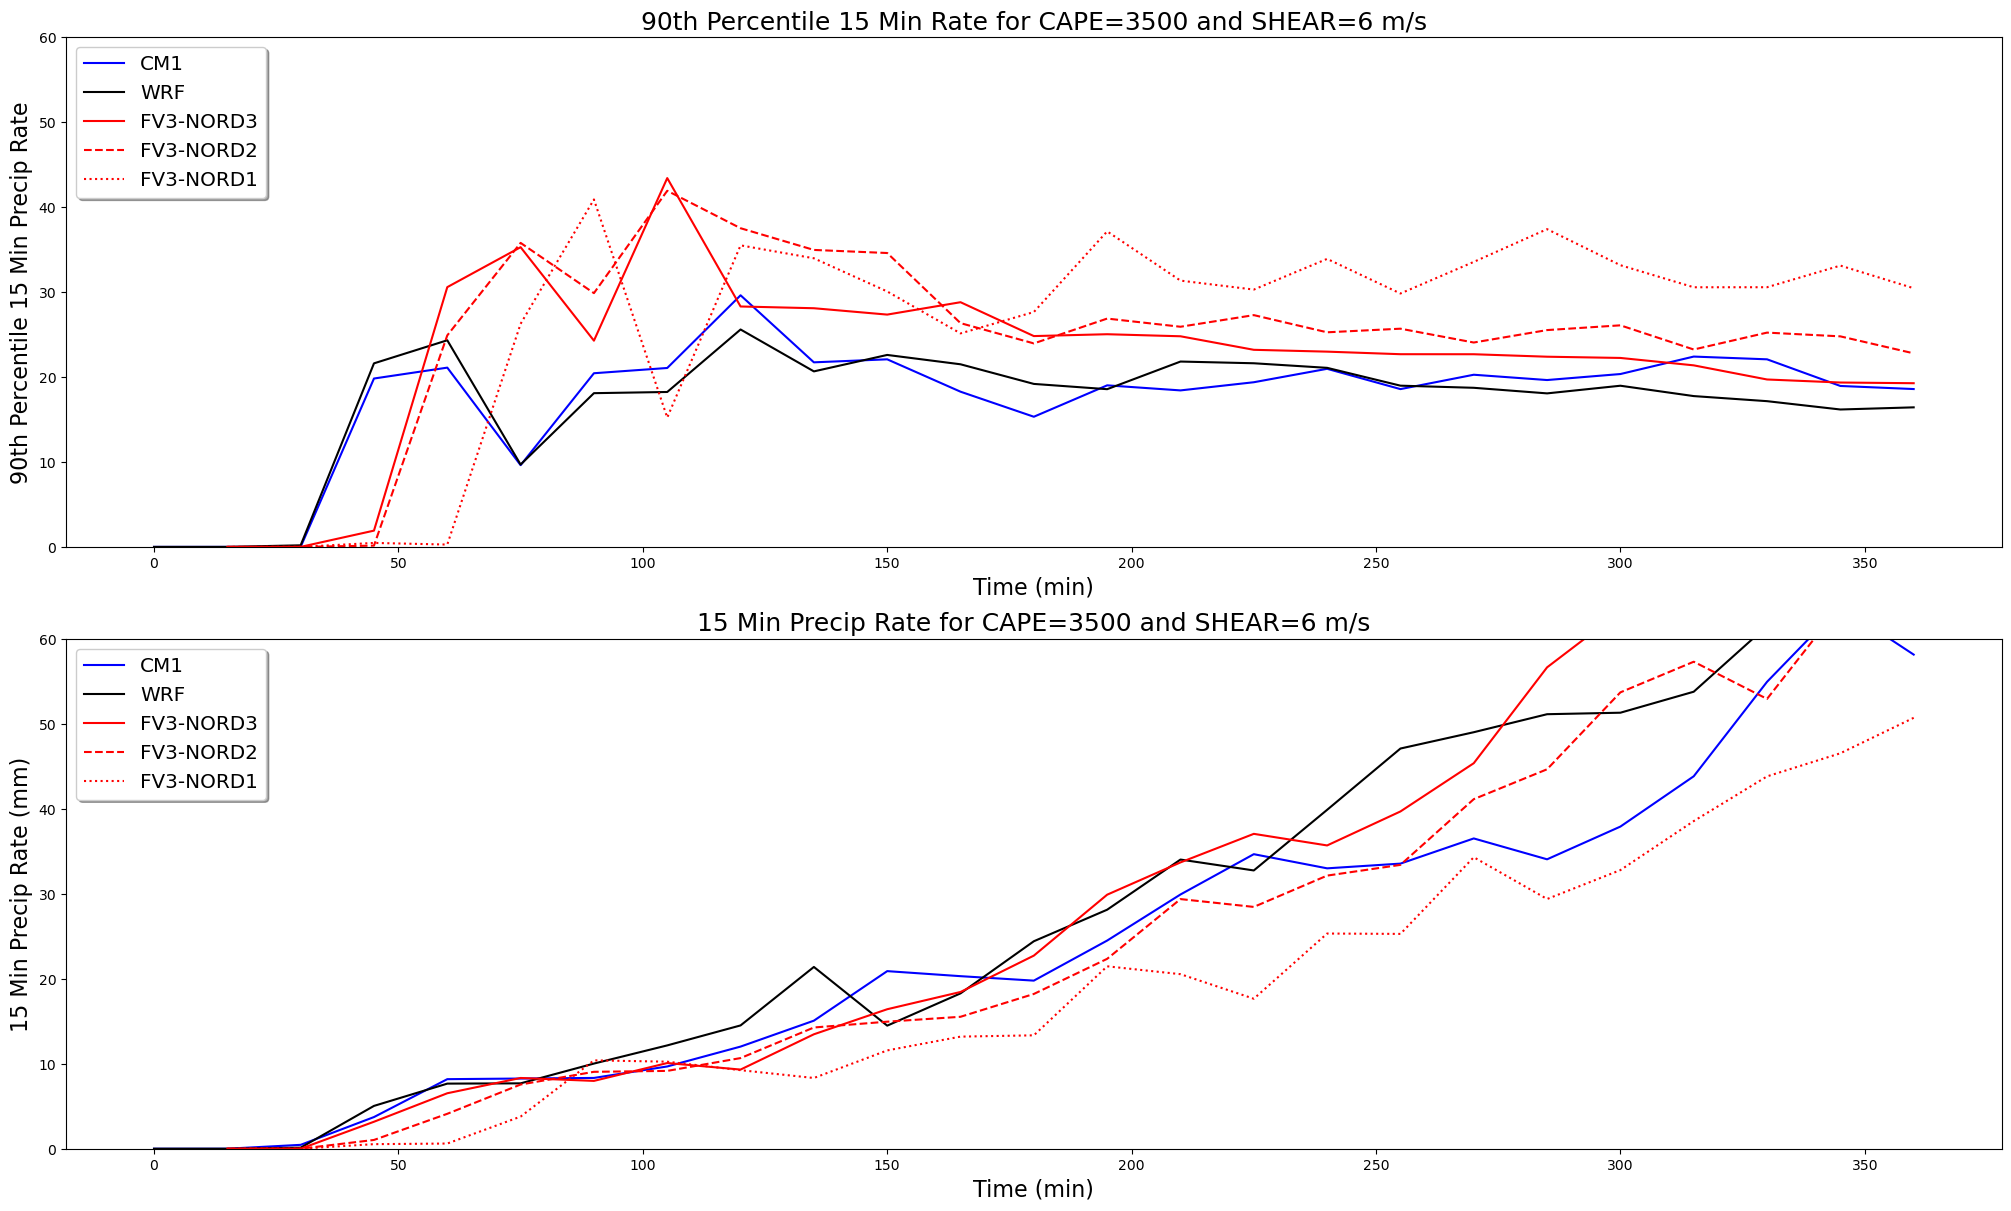

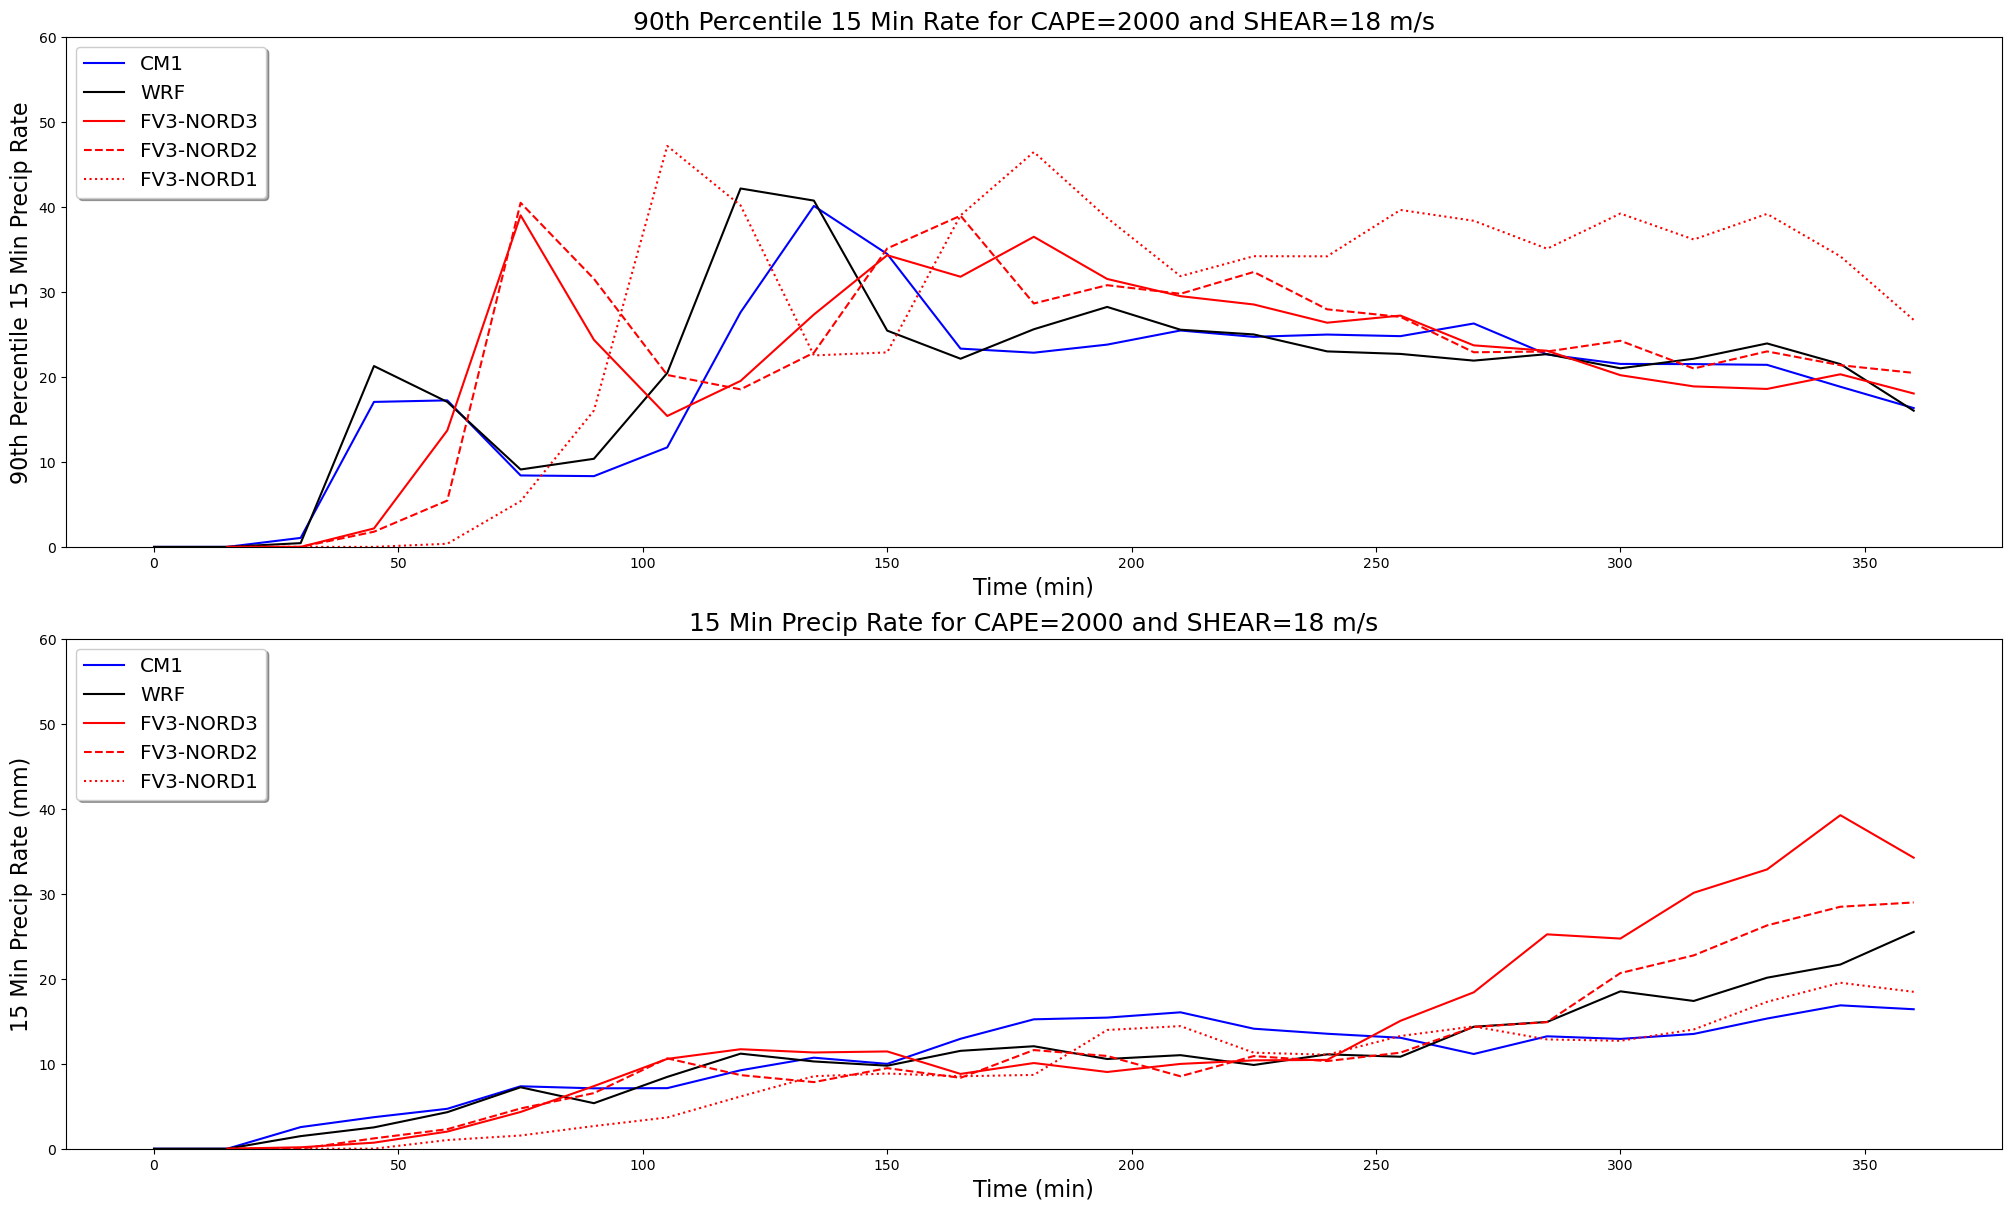

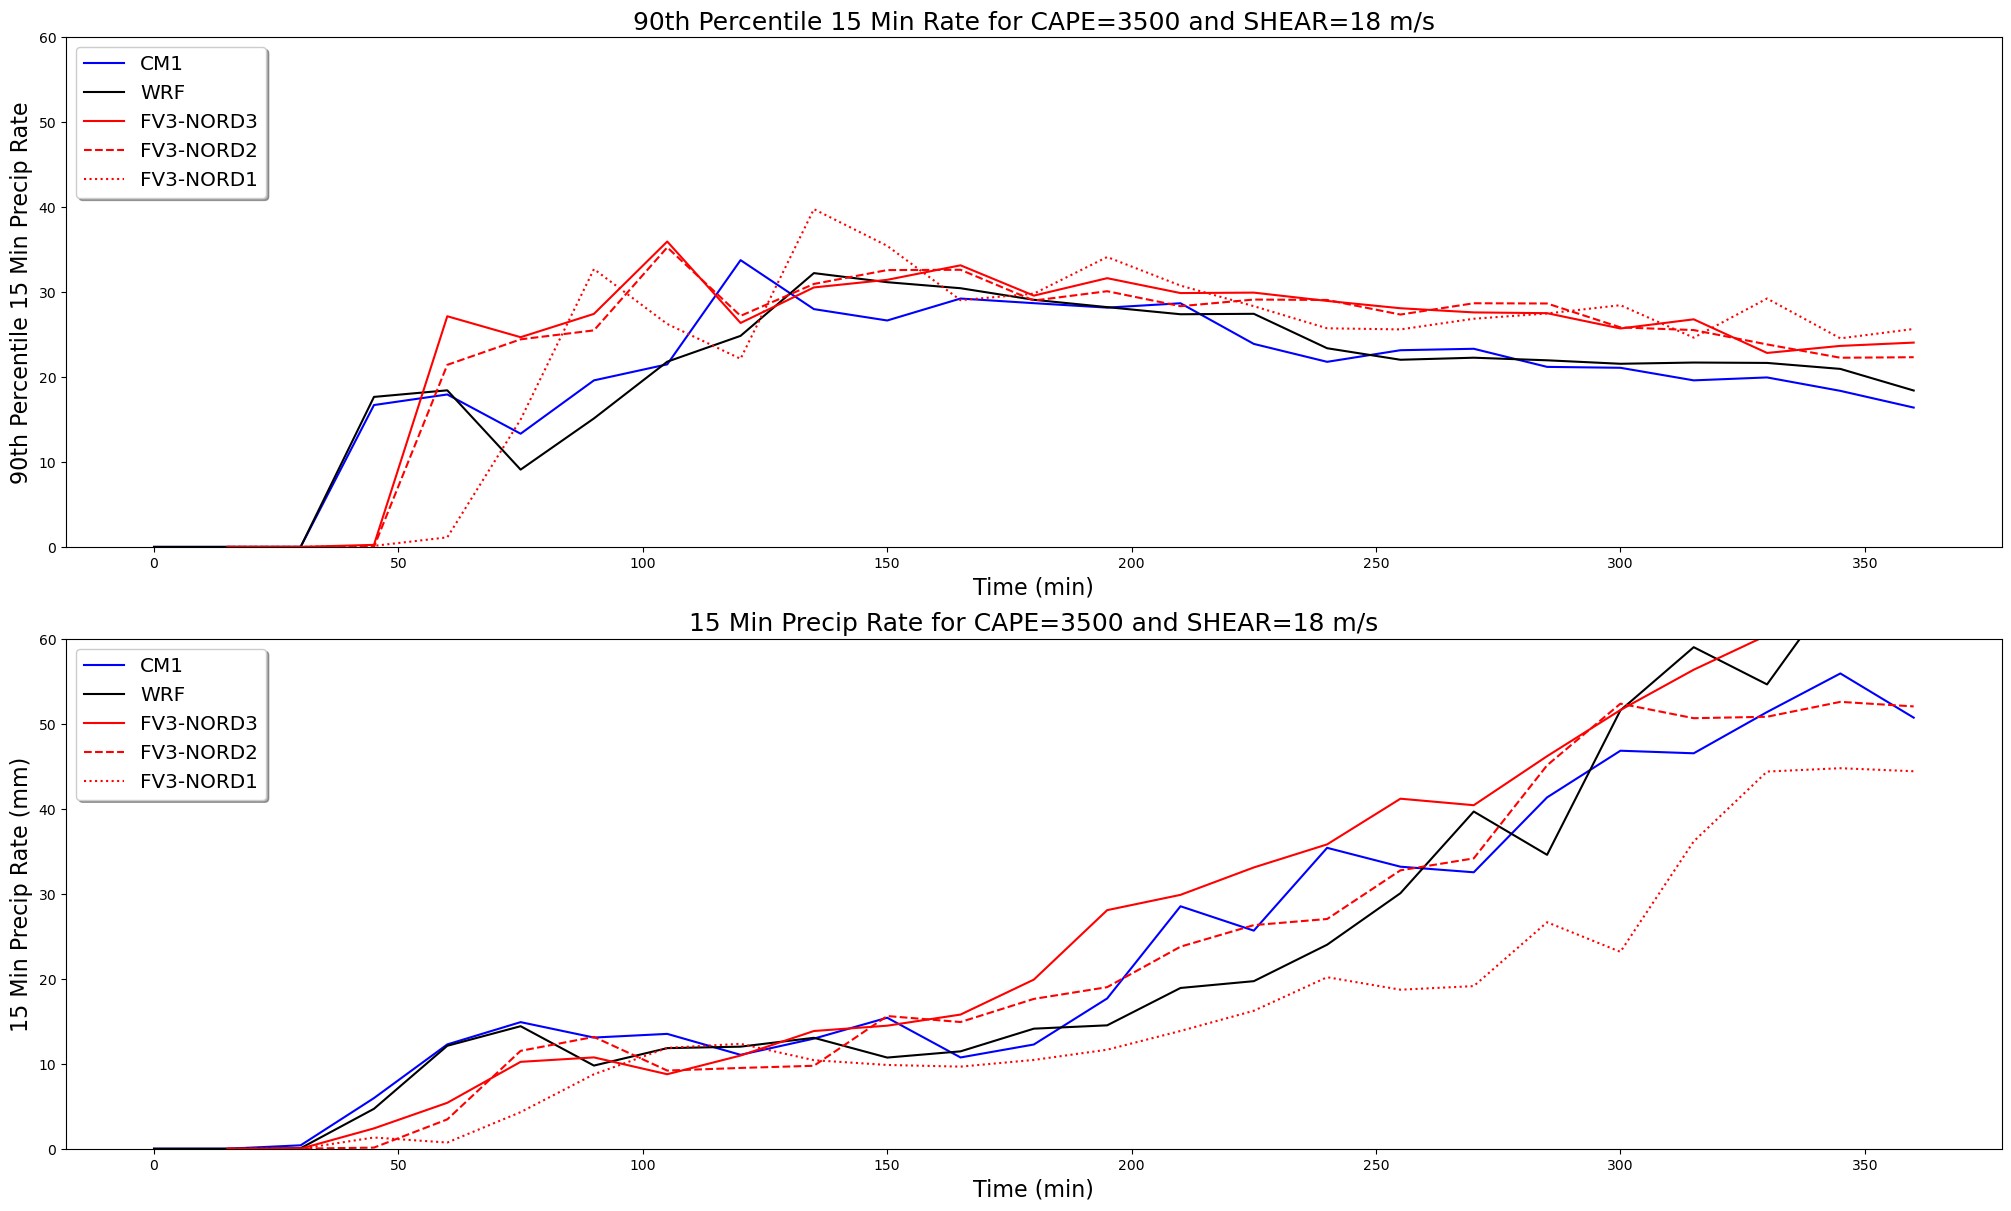

In [5]:
allcape = ("C2000", "C3500")
allshear = ("06", "18")

percent = 0.95

def plot_accum_prec(models, allcape, allshear, all_times=False):
    
    x = np.arange(5)

    if all_times:
        plim = [ [3.0e5, 5.0e5], [4.0e5, 6.5e5] ]
    else:
        plim = [ [60, 60], [60, 60] ]
        qlim = [ [60, 60], [60, 60] ]

    labels = []
    
    for cape in allcape:
        labels.append("%s" % (cape[1:]))
        
    for m, shear in enumerate(allshear):
        
        for n, cape in enumerate(allcape):
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(2,1, constrained_layout=True,figsize=(20,12))

            for key in models.keys():
                
                if all_times:
                    precip = models[key][label]['accum_prec']
                else:
                    inv       = models[key][label]['accum_prec'][::-1]
                    ppp       = np.zeros_like(inv)
                    precip    = np.ma.zeros_like(inv)
                    ppp[1:,:] = (inv[0:-1] - inv[1:])[::-1]
                    precip    = np.ma.masked_greater(ppp, 1.0e-1)
                
                    precip_percent = np.zeros((ppp.shape[0],))
                    
                    for k in np.arange(ppp.shape[0]):
                        ptime   = ppp[k].reshape(precip.shape[1]*precip.shape[2])
                        pthresh = ptime[ptime > 1.0e-01]
                        
                        psort   = np.sort(pthresh)
                        idx     = np.int(percent * psort.shape[0])
                        if idx > 0:
                            precip_percent[k] = np.mean(psort[idx:])
                        else:
                            precip_percent[k] = 0.0
                                            
                if key == 'solo':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle='-', label='FV3-NORD3')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle='-', label='FV3-NORD3')
                    
                if key == 'solo2':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle='--', label='FV3-NORD2')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle='--', label='FV3-NORD2')
                    
                if key == 'solo1':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle=':', label='FV3-NORD1')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle=':', label='FV3-NORD1')

                if key == 'cm1':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='b', linestyle='-', label='CM1')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='b', linestyle='-', label='CM1')
            
                if key == 'wrf':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='k', linestyle='-', label='WRF')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='k', linestyle='-', label='WRF')
                        
            ax[0].set_ylabel('90th Percentile 15 Min Precip Rate', fontsize=16)
            ax[1].set_ylabel('15 Min Precip Rate (mm)', fontsize=16)
            ax[0].set_title('90th Percentile 15 Min Rate for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            ax[1].set_title('15 Min Precip Rate for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            ax[0].set_ylim(0, qlim[m][n])
            ax[1].set_ylim(0, plim[m][n])
            
            for k in [0,1]:
                ax[k].set_xlabel('Time (min)', fontsize=16)
                
                legend = ax[k].legend(loc='upper left', shadow=True, fontsize='x-large')
            
            plt.savefig("Precipitation_Time_Series_Experiment_%s.png" % (label))
            plt.show()
            
###############################

plot_accum_prec(models, allcape, allshear, all_times=False)

In [ ]:
# Read in precip and w data

dirs    = {
           "solo": "/work/wicker/Odin_scr/solo",
           "wrf": "/work/wicker/WRF/WRF/test/em_quarter_ss",
           "cm1": "/work/wicker/Odin_scr/cm1r20.3/run",
          }

run      = {"solo": "squall_3km", "wrf": "squall_3km", "cm1": "squall_3km"}
run      = {"solo": "squall_3km_nord1"}
allcape = ("C2000", "C3500")
allshear = ("06", "12", "18")

solo = {}
cm1  = {}
wrf  = {}

for key in run.keys():
    
    field = {}
    
    for shear in allshear:
        for cape in allcape:

            label = "%s_%s" % (cape, shear)

            path = str(os.path.join(dirs[key], "%s_%s" % (run[key], label)))
            
            if key == 'solo':
                solo[label] = read_solo_fields(path, file_pattern=None, vars=['accum_prec'])
                
            if key == 'wrf':

                wrf[label] = read_wrf_fields(path, file_pattern=None, vars=['accum_prec'])

            if key == 'cm1':
                cm1[label] = read_cm1_fields(path, file_pattern=None, vars=['accum_prec'])
                
for key in run.keys():
    
    if key == 'solo':
        with open('precip/solo_%s_accum_prec.pkl' % run['solo'], 'wb') as handle:
            pickle.dump(solo, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if key == 'wrf':
        with open('precip/wrf_%s_accum_prec.pkl' % run['wrf'], 'wb') as handle:
            pickle.dump(wrf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    if key == 'cm1':
        with open('precip/cm1_%s_accum_prec.pkl' % run['cm1'], 'wb') as handle:
            pickle.dump(cm1, handle, protocol=pickle.HIGHEST_PROTOCOL)